In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random


In [2]:
# Load the saved day 7 features
loaded_day7_feats = torch.load('combined_sd7.pt')

# Load the saved day 10 features
loaded_day10_feats = torch.load('combined_sd10.pt')

# Verify the shapes
print(f"Loaded Day 7 Features Shape: {loaded_day7_feats.shape}")
print(f"Loaded Day 10 Features Shape: {loaded_day10_feats.shape}")


Loaded Day 7 Features Shape: torch.Size([638, 512])
Loaded Day 10 Features Shape: torch.Size([638, 512])


C:\Users\k54739\AppData\Local\Temp\ipykernel_16816\545892902.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_day7_feats = torch.load('combined_sd7.pt')
C:\Users\k

In [3]:
train_day7_feats = loaded_day7_feats 
train_day10_feats = loaded_day10_feats 

In [9]:
type(train_day7_feats)

torch.Tensor

In [4]:
train_day7_feats[0].shape

torch.Size([512])

In [8]:
'''def min_max_scaling_featurewise(data):
    data_min = data.min(dim=0).values  # Extract the minimum for each feature (column)
    data_max = data.max(dim=0).values  # Extract the maximum for each feature (column)
    scaled_data = (data - data_min) / (data_max - data_min )  # Add small epsilon to avoid division by zero
    return scaled_data, data_min, data_max'''


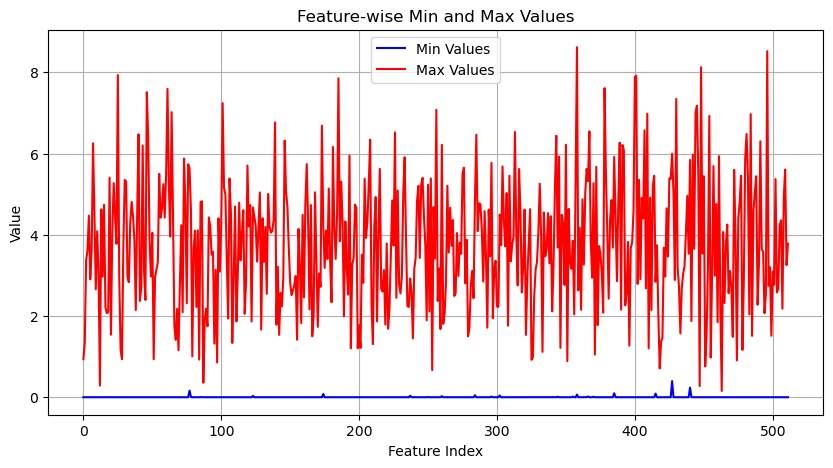

In [11]:
import matplotlib.pyplot as plt

# Plot the Min and Max values of each feature
plt.figure(figsize=(10, 5))
plt.plot(d7_min, label='Min Values', color='blue')
plt.plot(d7_max, label='Max Values', color='red')
plt.title('Feature-wise Min and Max Values')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


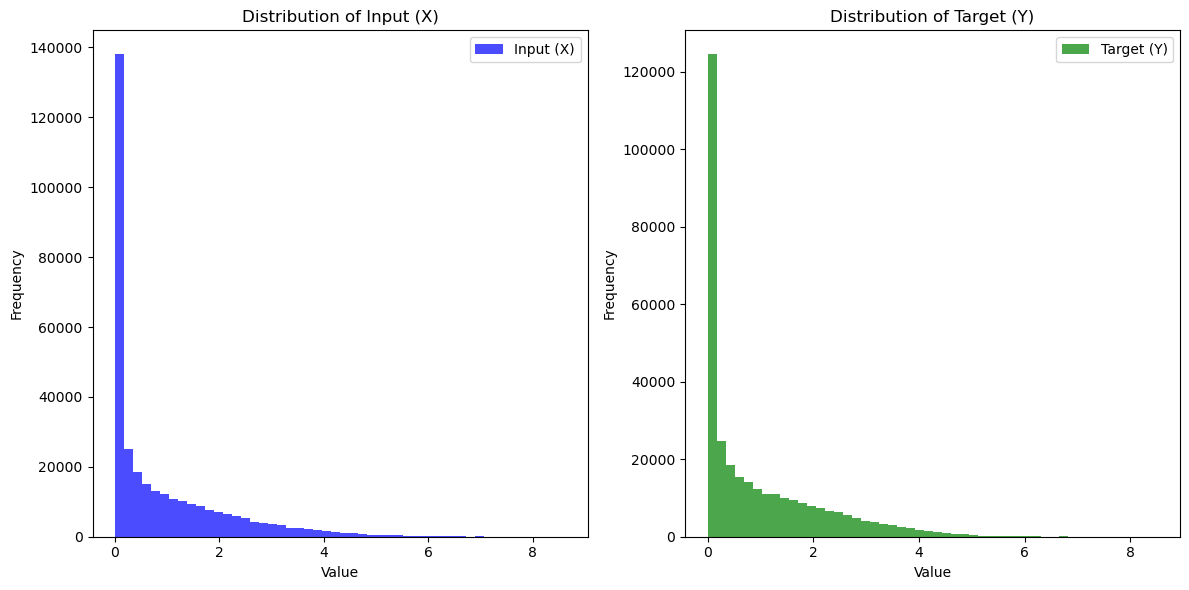

Input (X): Mean=0.8915, Std=1.1800
Target (Y): Mean=0.9677, Std=1.1798


In [5]:
import matplotlib.pyplot as plt

# Plot histograms for input (X) and target (Y)
plt.figure(figsize=(12, 6))

# Flatten tensors to 1D for easier visualization
train_day7_feats_flat = train_day7_feats.flatten().cpu().numpy()
train_day10_feats_flat = train_day10_feats.flatten().cpu().numpy()

# Input (X) histogram
plt.subplot(1, 2, 1)
plt.hist(train_day7_feats_flat, bins=50, color='blue', alpha=0.7, label='Input (X)')
plt.title('Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram
plt.subplot(1, 2, 2)
plt.hist(train_day10_feats_flat, bins=50, color='green', alpha=0.7, label='Target (Y)')
plt.title('Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Input (X): Mean={train_day7_feats.mean():.4f}, Std={train_day7_feats.std():.4f}")
print(f"Target (Y): Mean={train_day10_feats.mean():.4f}, Std={train_day10_feats.std():.4f}")


In [10]:
# Convert PyTorch tensor to NumPy array
train_day7_feats_numpy = train_day7_feats.numpy()
train_day10_feats_numpy = train_day10_feats.numpy()

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Initialize separate MinMaxScaler for day7 and day10
scaler_day7 = MinMaxScaler()
scaler_day10 = MinMaxScaler()

# Fit and transform the train_day7_feats
train_day7_feats_minmaxed = scaler_day7.fit_transform(train_day7_feats_numpy)
print(train_day7_feats_minmaxed.shape)
# Get min and max values for day7
min_values_day7 = scaler_day7.data_min_
max_values_day7 = scaler_day7.data_max_

print(min_values_day7.shape)
print(max_values_day7.shape)
#print("Min values for day7:", min_values_day7)
#print("Max values for day7:", max_values_day7)

# Fit and transform the train_day10_feats (target)
train_day10_feats_minmaxed = scaler_day10.fit_transform(train_day10_feats_numpy)
print(train_day10_feats_minmaxed.shape)
# Get min and max values for day10
min_values_day10 = scaler_day10.data_min_
max_values_day10 = scaler_day10.data_max_

print(min_values_day10.shape)
print(max_values_day10.shape)
#print("Min values for day10:", min_values_day10)
#print("Max values for day10:", max_values_day10)

# Convert the scaled data back to PyTorch tensors (optional)
train_day7_feats_minmaxed = torch.tensor(train_day7_feats_minmaxed)
train_day10_feats_minmaxed = torch.tensor(train_day10_feats_minmaxed)


(638, 512)
(512,)
(512,)
(638, 512)
(512,)
(512,)


In [28]:
import joblib

# Save the scalers to disk
joblib.dump(scaler_day7, 'scaler_day7.pkl')
joblib.dump(scaler_day10, 'scaler_day10.pkl')

print("Scalers saved!")


Scalers saved!


In [14]:
type(train_day7_feats_minmaxed)

torch.Tensor

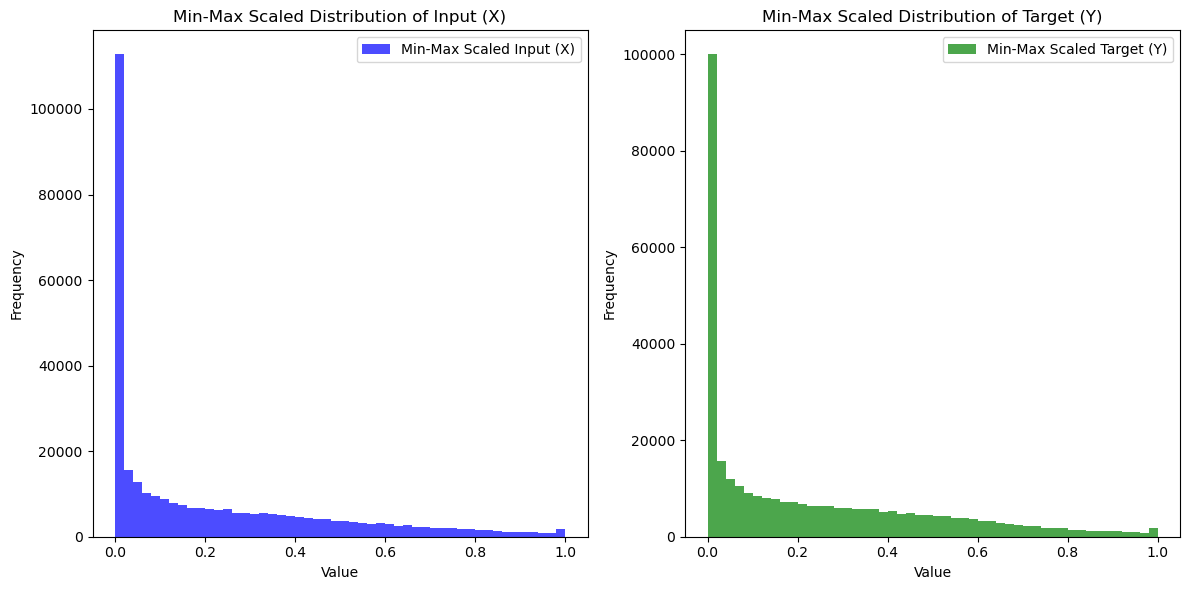

In [15]:
import matplotlib.pyplot as plt

# Flatten the tensors for easier visualization
train_day7_feats_minmaxed_flat = train_day7_feats_minmaxed.flatten().cpu().numpy()
train_day10_feats_minmaxed_flat = train_day10_feats_minmaxed.flatten().cpu().numpy()

# Plot histograms
plt.figure(figsize=(12, 6))

# Input (X) histogram after Min-Max scaling
plt.subplot(1, 2, 1)
plt.hist(train_day7_feats_minmaxed_flat, bins=50, color='blue', alpha=0.7, label='Min-Max Scaled Input (X)')
plt.title('Min-Max Scaled Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram after Min-Max scaling
plt.subplot(1, 2, 2)
plt.hist(train_day10_feats_minmaxed_flat, bins=50, color='green', alpha=0.7, label='Min-Max Scaled Target (Y)')
plt.title('Min-Max Scaled Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [17]:
model = FeaturePredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [18]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

In [19]:
from torch.utils.data import TensorDataset

optimizer_class = torch.optim.Adam



In [20]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import numpy as np
import torch


In [21]:

class EarlyStopping:
    def __init__(self, patience=10, delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after the last validation loss improvement.
            delta (float): Minimum change in the validation loss to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.no_improvement_epochs = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_epochs = 0
        else:
            self.no_improvement_epochs += 1
            if self.no_improvement_epochs >= self.patience:
                self.early_stop = True


def cross_validate_with_early_stopping(
    model_class, dataset, criterion, optimizer_class, num_epochs=50, n_splits=5, patience=10, device='cuda'
):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    histories = []
    best_models = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{n_splits}")

        # Create subsets for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        # Initialize the model, optimizer, and early stopping for this fold
        model = model_class().to(device)
        optimizer = optimizer_class(model.parameters(), lr=1e-4)
        early_stopping = EarlyStopping(patience=patience)

        # Training and validation loop
        history = {'train_loss': [], 'val_loss': []}
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            for batch_inputs, batch_targets in train_loader:
                batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

                # Forward pass
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_targets)
                train_loss += loss.item()

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss /= len(train_loader)
            history['train_loss'].append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_inputs, batch_targets in val_loader:
                    batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
                    outputs = model(batch_inputs)
                    loss = criterion(outputs, batch_targets)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            history['val_loss'].append(val_loss)

            print(f"Epoch [{epoch + 1}/{num_epochs}] Fold {fold + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Check early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch + 1} for fold {fold + 1}")
                break

        # Save the best model for this fold
        best_models.append(model.state_dict())
        histories.append(history)

    return histories, best_models



In [22]:
# MIN MAX
dataset = TensorDataset(train_day7_feats_minmaxed, train_day10_feats_minmaxed)

cv_histories, best_models = cross_validate_with_early_stopping(
    model_class=FeaturePredictor,
    dataset=dataset,
    criterion=nn.MSELoss(),
    optimizer_class=torch.optim.Adam,
    num_epochs=2000,
    patience=500
)


Fold 1/5
Epoch [1/2000] Fold 1, Train Loss: 0.1192, Val Loss: 0.1163
Epoch [2/2000] Fold 1, Train Loss: 0.1124, Val Loss: 0.1091
Epoch [3/2000] Fold 1, Train Loss: 0.1045, Val Loss: 0.1002
Epoch [4/2000] Fold 1, Train Loss: 0.0945, Val Loss: 0.0890
Epoch [5/2000] Fold 1, Train Loss: 0.0824, Val Loss: 0.0762
Epoch [6/2000] Fold 1, Train Loss: 0.0697, Val Loss: 0.0643
Epoch [7/2000] Fold 1, Train Loss: 0.0593, Val Loss: 0.0568
Epoch [8/2000] Fold 1, Train Loss: 0.0541, Val Loss: 0.0538
Epoch [9/2000] Fold 1, Train Loss: 0.0518, Val Loss: 0.0525
Epoch [10/2000] Fold 1, Train Loss: 0.0509, Val Loss: 0.0521
Epoch [11/2000] Fold 1, Train Loss: 0.0506, Val Loss: 0.0519
Epoch [12/2000] Fold 1, Train Loss: 0.0504, Val Loss: 0.0518
Epoch [13/2000] Fold 1, Train Loss: 0.0503, Val Loss: 0.0516
Epoch [14/2000] Fold 1, Train Loss: 0.0502, Val Loss: 0.0515
Epoch [15/2000] Fold 1, Train Loss: 0.0501, Val Loss: 0.0515
Epoch [16/2000] Fold 1, Train Loss: 0.0499, Val Loss: 0.0513
Epoch [17/2000] Fold 1, 

In [23]:
# Example: Average validation loss across folds
avg_val_loss = np.mean([history['val_loss'][-1] for history in cv_histories])
print(f"Average Validation Loss: {avg_val_loss:.4f}")


Average Validation Loss: 0.0295


In [24]:
# Analyze the best results for each fold outside the training function
for fold_idx, history in enumerate(cv_histories):
    # Find the epoch with the lowest validation loss
    best_epoch = int(np.argmin(history['val_loss'])) + 1  # Adding 1 because epochs are 1-indexed
    best_val_loss = history['val_loss'][best_epoch - 1]  # Accessing the loss using 0-based index
    best_train_loss = history['train_loss'][best_epoch - 1]

    print(f"Fold {fold_idx + 1}:")
    print(f"  Best Validation Loss = {best_val_loss:.4f}")
    print(f"  Corresponding Training Loss = {best_train_loss:.4f}")
    print(f"  Best Epoch = {best_epoch}")


Fold 1:
  Best Validation Loss = 0.0269
  Corresponding Training Loss = 0.0215
  Best Epoch = 671
Fold 2:
  Best Validation Loss = 0.0280
  Corresponding Training Loss = 0.0223
  Best Epoch = 540
Fold 3:
  Best Validation Loss = 0.0284
  Corresponding Training Loss = 0.0190
  Best Epoch = 846
Fold 4:
  Best Validation Loss = 0.0280
  Corresponding Training Loss = 0.0223
  Best Epoch = 485
Fold 5:
  Best Validation Loss = 0.0264
  Corresponding Training Loss = 0.0230
  Best Epoch = 949


In [25]:
import torch

# Save each fold's best model to the current directory
for i, model_state in enumerate(best_models):
    save_path = f'featwiseNorm_model_{i+1}.pth'  # Save in the current directory
    torch.save(model_state, save_path)

print("Models saved to the current directory.")


Models saved to the current directory.


In [26]:
def plot_loss_curves_separately(cv_histories):
    """
    Plot training and validation loss curves for each fold in separate figures.
    
    Args:
        cv_histories (list): List of loss histories for each fold.
    """
    # Plot Training Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, len(history['train_loss']) + 1)  # Dynamically set range
        plt.plot(epochs, history['train_loss'], label=f'Fold {fold + 1} Train Loss')
    plt.title('Training Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, len(history['val_loss']) + 1)  # Dynamically set range
        plt.plot(epochs, history['val_loss'], label=f'Fold {fold + 1} Val Loss', linestyle='--')
    plt.title('Validation Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


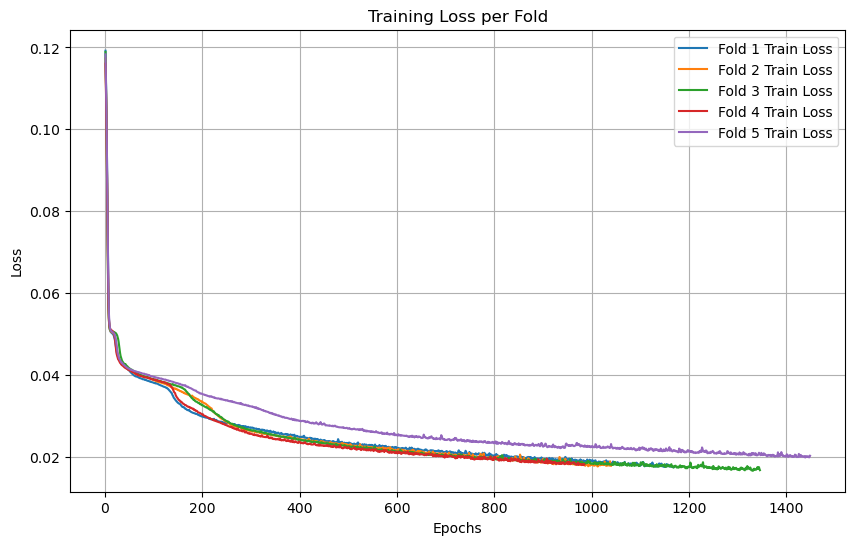

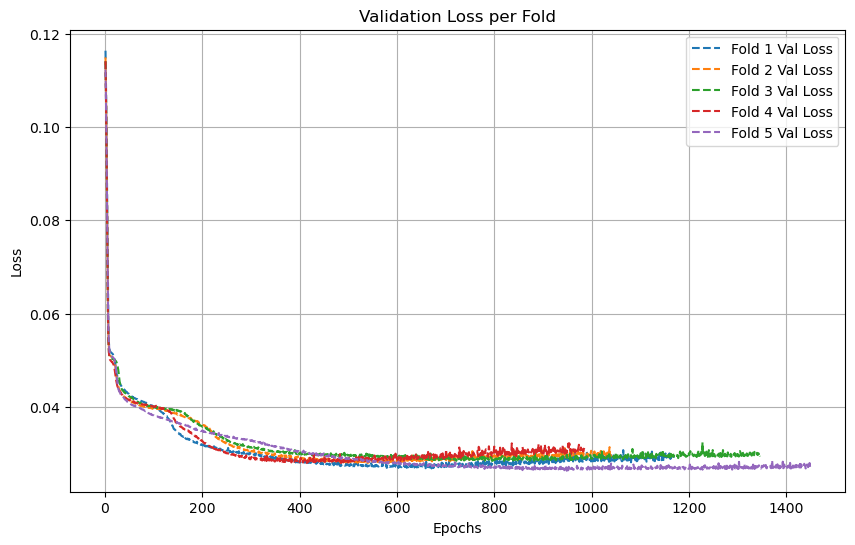

In [27]:
import matplotlib.pyplot as plt
plot_loss_curves_separately(cv_histories)
